# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [69]:
! pip install Pillow

In [70]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [71]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [72]:
!ls MNIST

processed  raw


In [73]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [74]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

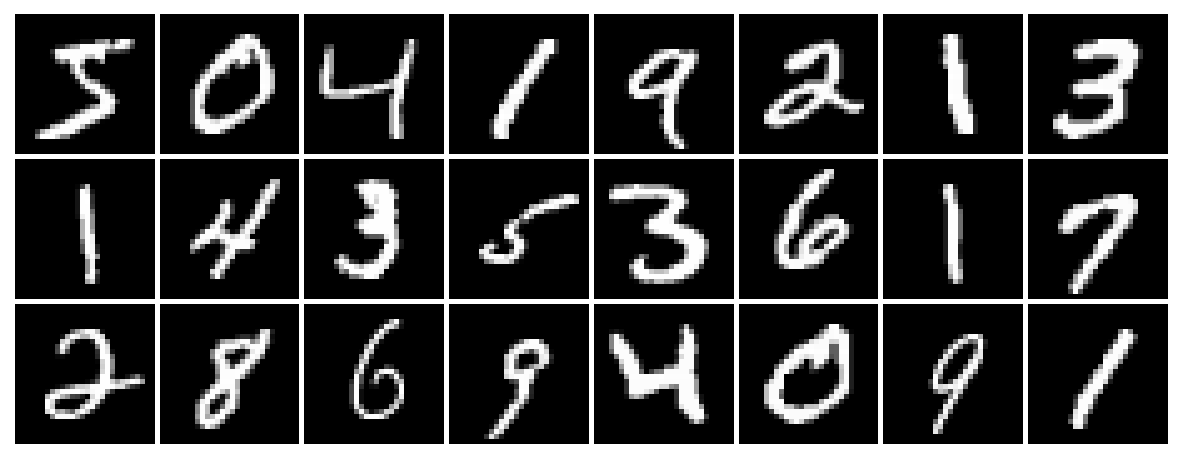

In [75]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


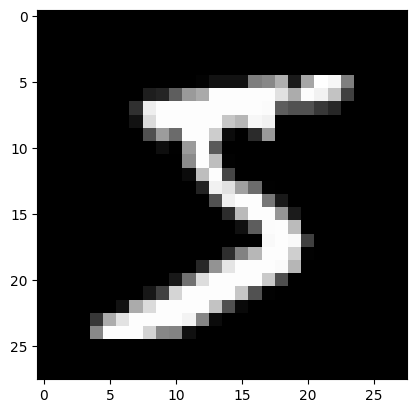

In [76]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [77]:
model = torch.nn.Linear(28*28, 10) # 28*28 (784) atributos de entrada e 10 neurônios na saída
# 784 * 10 + 10 = 7850 parâmetros

### Testando um predict com poucas amostras

In [78]:
xin = x_train[:5].view(-1,28*28)
score = model(xin)
score

tensor([[ 0.4026, -0.0735,  0.0371,  0.0751,  0.0903, -0.0155,  0.0170,  0.0988,
         -0.1111, -0.1351],
        [ 0.0368,  0.1461, -0.0430, -0.1695, -0.0007, -0.1681, -0.0484, -0.1137,
          0.0581, -0.1768],
        [-0.1395,  0.2177,  0.0043,  0.1522, -0.2467,  0.0779, -0.0030,  0.1418,
         -0.0778,  0.0551],
        [ 0.0962, -0.0322,  0.1847,  0.1480, -0.0829,  0.1258, -0.0187, -0.1734,
         -0.2243,  0.0832],
        [-0.0968,  0.1353,  0.1110, -0.0093, -0.1670,  0.0717,  0.0301,  0.1799,
         -0.2340,  0.1072]], grad_fn=<AddmmBackward0>)

In [79]:
import torch.nn as nn
import torch.nn.functional as F
prob,y_pred = torch.max(F.softmax(score,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([0, 1, 1, 2, 7])
tensor([0.1423, 0.1207, 0.1210, 0.1180, 0.1172], grad_fn=<MaxBackward0>)


## Treinamento

### Inicialização dos parâmetros

In [80]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [81]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-k5zpx4da
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-k5zpx4da
  Resolved https://github.com/szagoruyko/pytorchviz to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Preparing metadata (setup.py) ... done


In [82]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3140, grad_fn=<NllLossBackward0>)

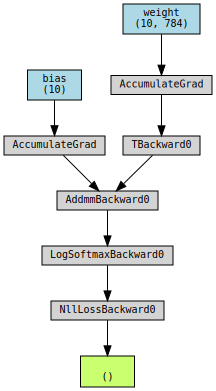

In [83]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [84]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = x_train.view(-1, 28 * 28)
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, y_train)

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [85]:
print('Final loss:', loss.item())

Final loss: 0.26525577902793884


### Visualizando gráfico de perda durante o treinamento

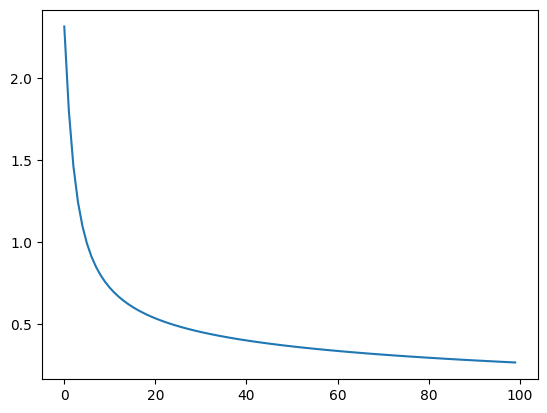

In [86]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [87]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.939


### Matriz de confusão com dados de treinamento e teste

In [88]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,111,2,0,0,0,2,3,1,0
2,0,0,90,2,0,1,0,1,2,1
3,0,0,0,87,0,2,0,0,0,0
4,0,0,1,0,102,2,1,1,0,3
5,0,2,0,1,0,81,1,0,2,1
6,1,0,1,1,2,2,89,0,0,0
7,0,1,1,1,0,0,0,111,0,3
8,0,2,2,0,0,2,0,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


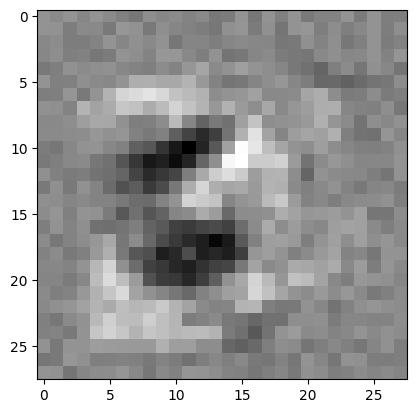

In [89]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

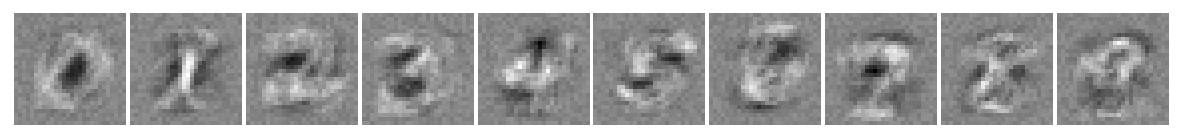

In [90]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [91]:
model2 = torch.nn.Linear(28*28, 10) # 28*28 (784) atributos de entrada e 10 neurônios na saída
epochs = 100
learningRate = 0.5

# CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model2.parameters(), lr=learningRate)

import numpy
losses = []
zs = []

for i in range(epochs):
  # Tranformar a entrada para umd imensão
  imputs = x_train.view(-1, 28 * 28)
  # Predict da rede
  outputs = model2(inputs)

  #z0 a z9
  zs.append(outputs[1].detach().numpy())

  # calcula a perda
  loss = criterion(outputs, y_train)

  # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

  _, predicts = torch.max(outputs, 1)

  y_pred = predicts.data
  accuracy = (y_pred.numpy() == y_train.numpy()).mean()
  print('Epoch[{}/{}], loss: {:.3f}, acc: {:.3f}'
            .format(i+1, epochs, loss.data, accuracy))


Epoch[1/100], loss: 2.312, acc: 0.085
Epoch[2/100], loss: 1.805, acc: 0.599
Epoch[3/100], loss: 1.468, acc: 0.773
Epoch[4/100], loss: 1.248, acc: 0.779
Epoch[5/100], loss: 1.098, acc: 0.806
Epoch[6/100], loss: 0.990, acc: 0.816
Epoch[7/100], loss: 0.909, acc: 0.828
Epoch[8/100], loss: 0.847, acc: 0.830
Epoch[9/100], loss: 0.797, acc: 0.845
Epoch[10/100], loss: 0.756, acc: 0.848
Epoch[11/100], loss: 0.721, acc: 0.851
Epoch[12/100], loss: 0.691, acc: 0.857
Epoch[13/100], loss: 0.665, acc: 0.865
Epoch[14/100], loss: 0.642, acc: 0.867
Epoch[15/100], loss: 0.622, acc: 0.871
Epoch[16/100], loss: 0.604, acc: 0.873
Epoch[17/100], loss: 0.587, acc: 0.877
Epoch[18/100], loss: 0.572, acc: 0.880
Epoch[19/100], loss: 0.559, acc: 0.882
Epoch[20/100], loss: 0.546, acc: 0.885
Epoch[21/100], loss: 0.534, acc: 0.886
Epoch[22/100], loss: 0.523, acc: 0.888
Epoch[23/100], loss: 0.513, acc: 0.889
Epoch[24/100], loss: 0.504, acc: 0.892
Epoch[25/100], loss: 0.495, acc: 0.893
Epoch[26/100], loss: 0.486, acc: 0

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

Epoch[1/100]
weight: torch.Size([10, 784])


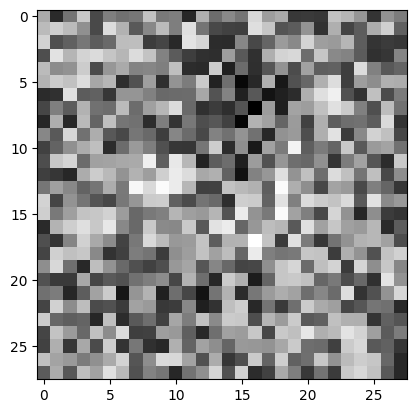

Epoch[2/100]
weight: torch.Size([10, 784])


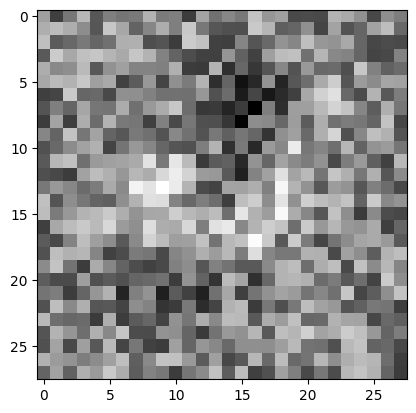

Epoch[3/100]
weight: torch.Size([10, 784])


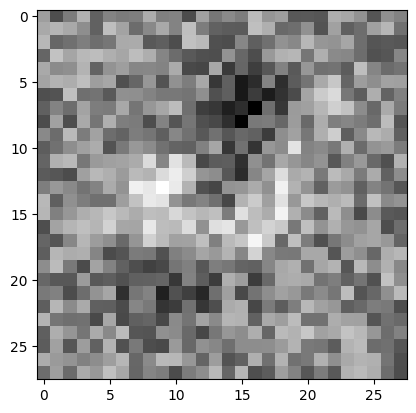

Epoch[4/100]
weight: torch.Size([10, 784])


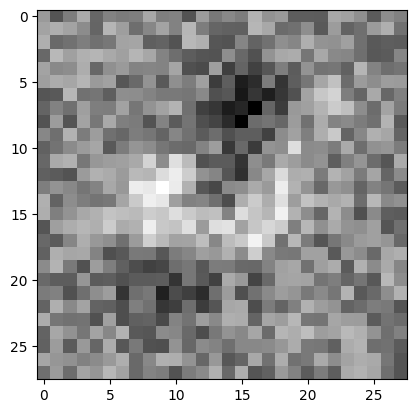

Epoch[5/100]
weight: torch.Size([10, 784])


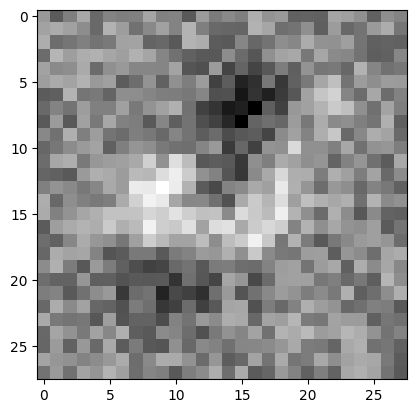

Epoch[6/100]
weight: torch.Size([10, 784])


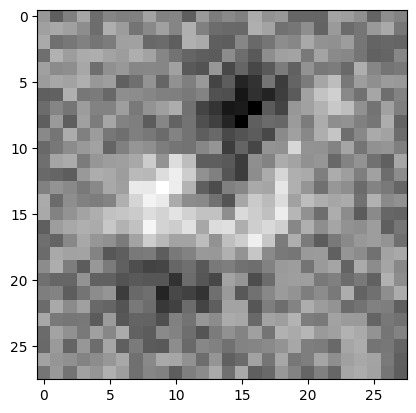

Epoch[7/100]
weight: torch.Size([10, 784])


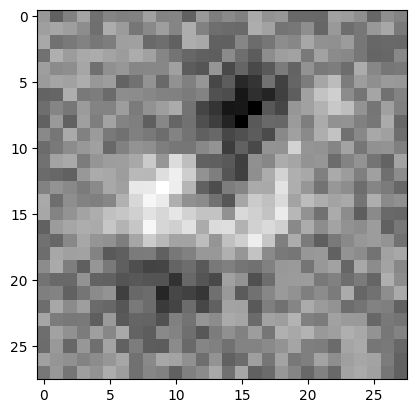

Epoch[8/100]
weight: torch.Size([10, 784])


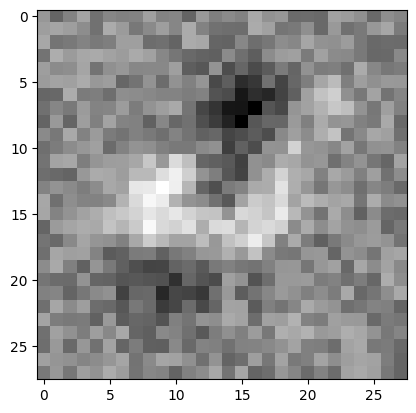

Epoch[9/100]
weight: torch.Size([10, 784])


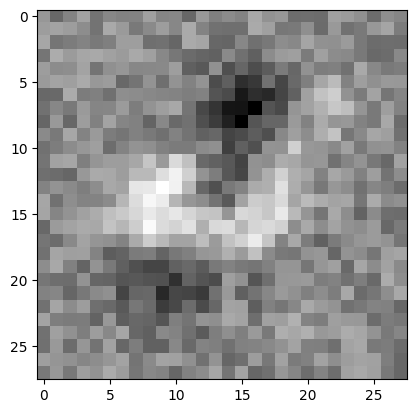

Epoch[10/100]
weight: torch.Size([10, 784])


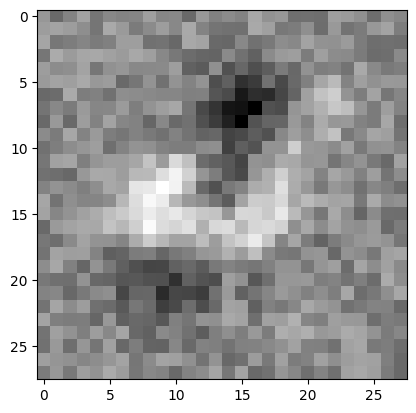

Epoch[11/100]
weight: torch.Size([10, 784])


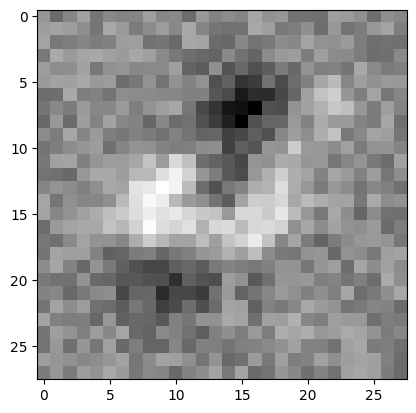

Epoch[12/100]
weight: torch.Size([10, 784])


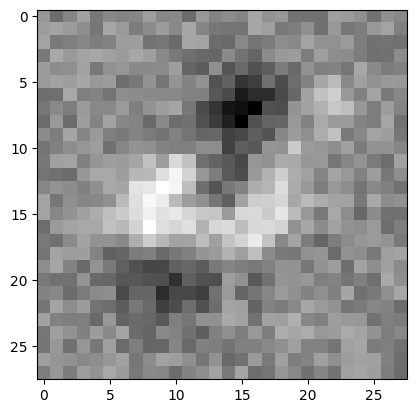

Epoch[13/100]
weight: torch.Size([10, 784])


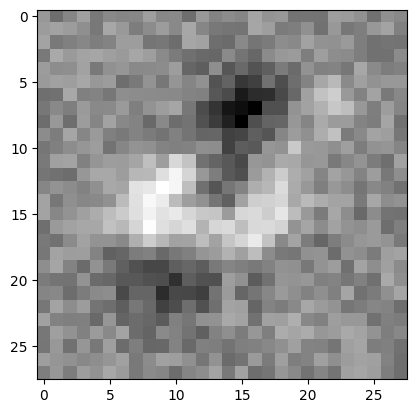

Epoch[14/100]
weight: torch.Size([10, 784])


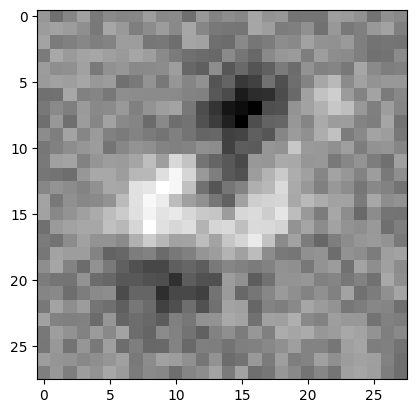

Epoch[15/100]
weight: torch.Size([10, 784])


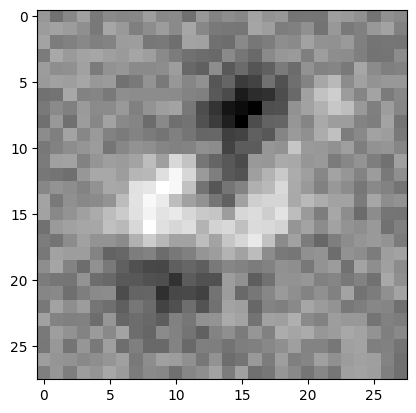

Epoch[16/100]
weight: torch.Size([10, 784])


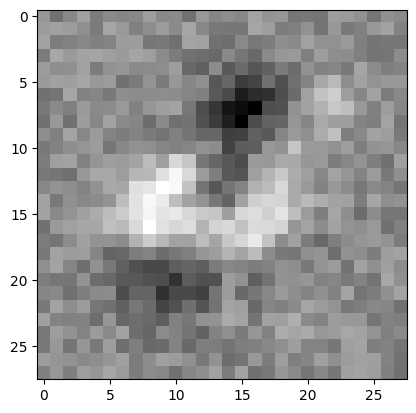

Epoch[17/100]
weight: torch.Size([10, 784])


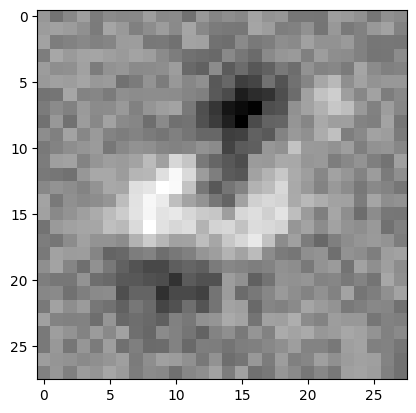

Epoch[18/100]
weight: torch.Size([10, 784])


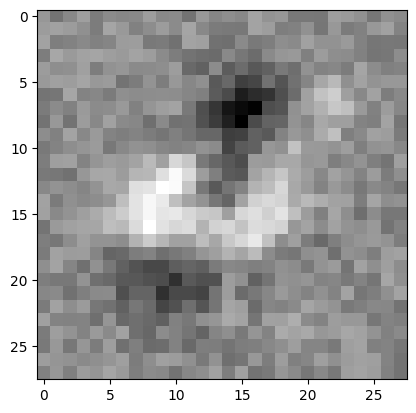

Epoch[19/100]
weight: torch.Size([10, 784])


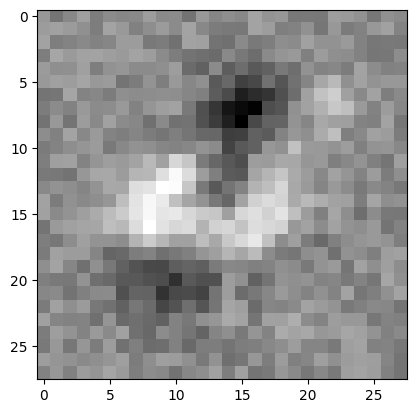

Epoch[20/100]
weight: torch.Size([10, 784])


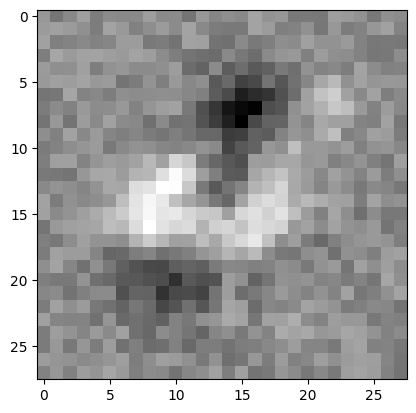

Epoch[21/100]
weight: torch.Size([10, 784])


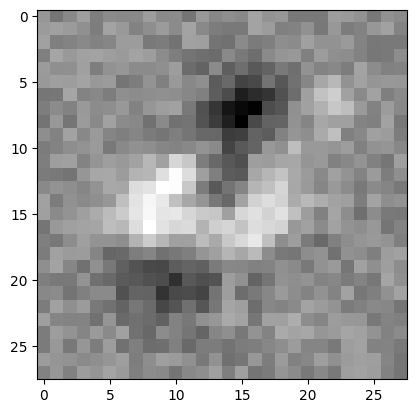

Epoch[22/100]
weight: torch.Size([10, 784])


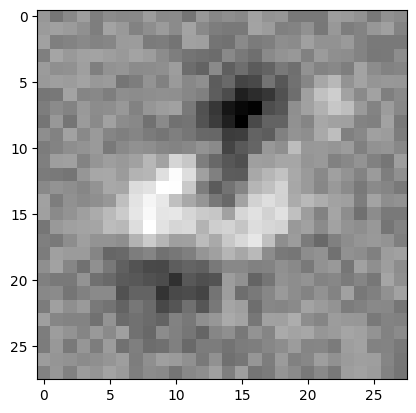

Epoch[23/100]
weight: torch.Size([10, 784])


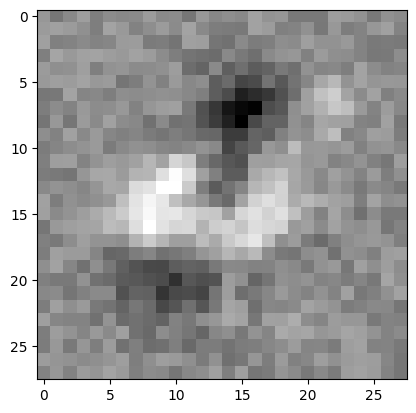

Epoch[24/100]
weight: torch.Size([10, 784])


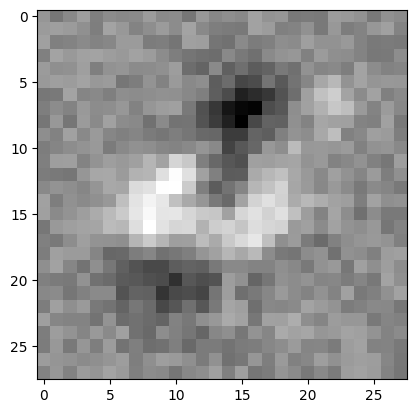

Epoch[25/100]
weight: torch.Size([10, 784])


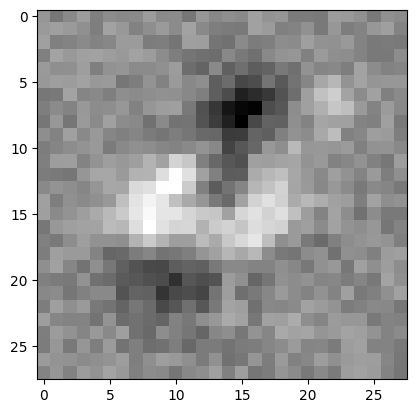

Epoch[26/100]
weight: torch.Size([10, 784])


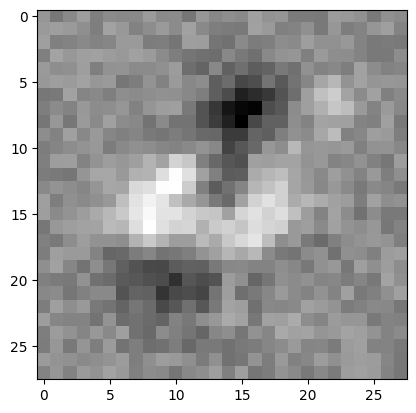

Epoch[27/100]
weight: torch.Size([10, 784])


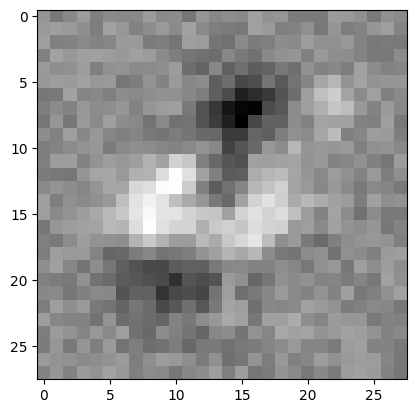

Epoch[28/100]
weight: torch.Size([10, 784])


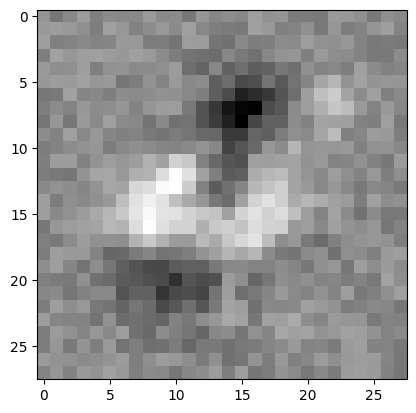

Epoch[29/100]
weight: torch.Size([10, 784])


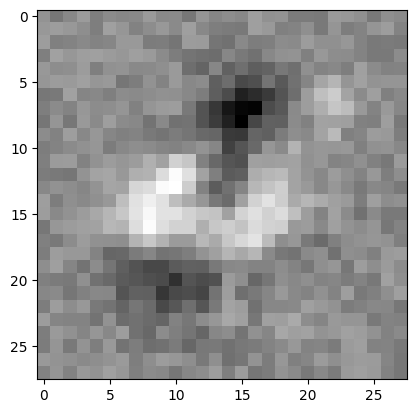

Epoch[30/100]
weight: torch.Size([10, 784])


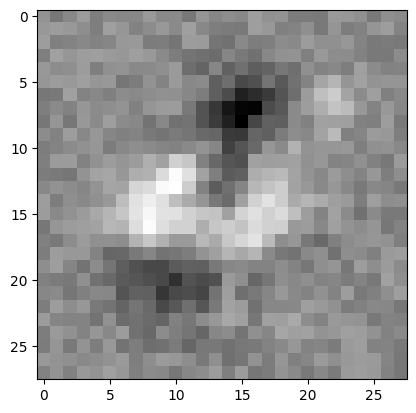

Epoch[31/100]
weight: torch.Size([10, 784])


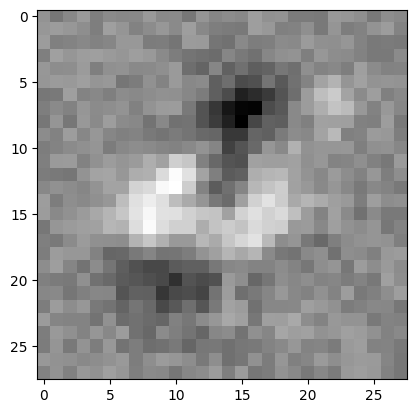

Epoch[32/100]
weight: torch.Size([10, 784])


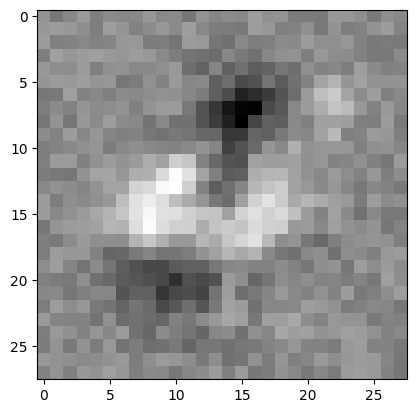

Epoch[33/100]
weight: torch.Size([10, 784])


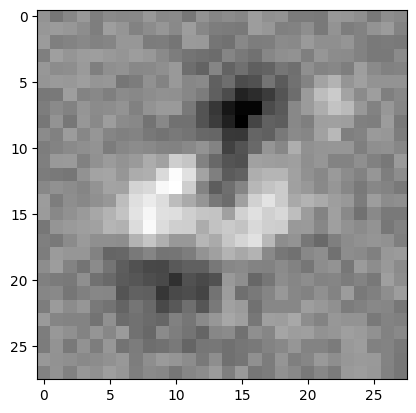

Epoch[34/100]
weight: torch.Size([10, 784])


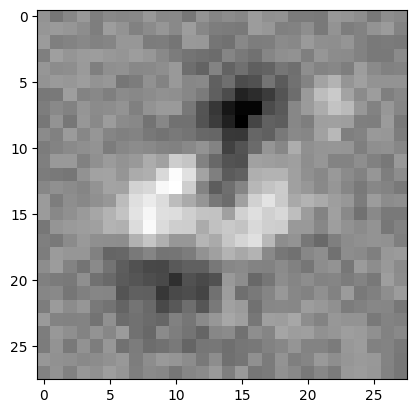

Epoch[35/100]
weight: torch.Size([10, 784])


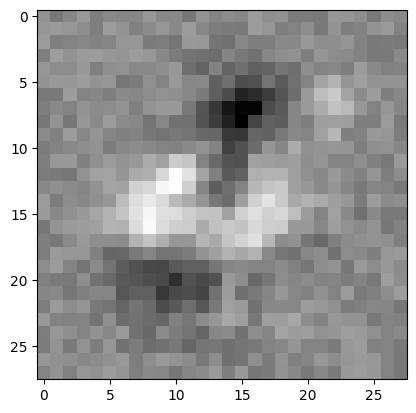

Epoch[36/100]
weight: torch.Size([10, 784])


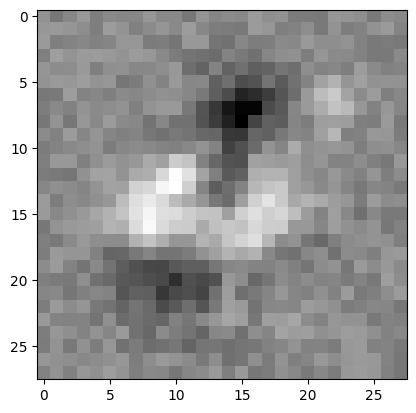

Epoch[37/100]
weight: torch.Size([10, 784])


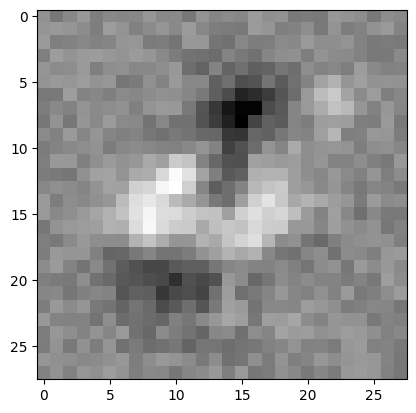

Epoch[38/100]
weight: torch.Size([10, 784])


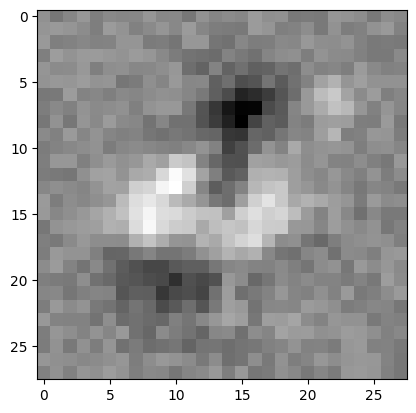

Epoch[39/100]
weight: torch.Size([10, 784])


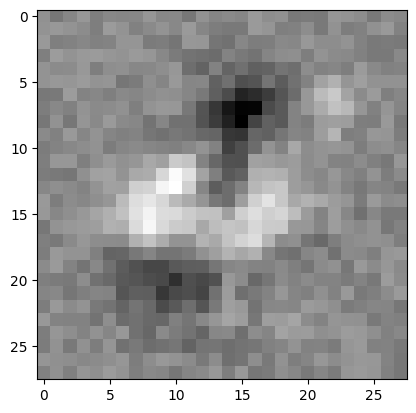

Epoch[40/100]
weight: torch.Size([10, 784])


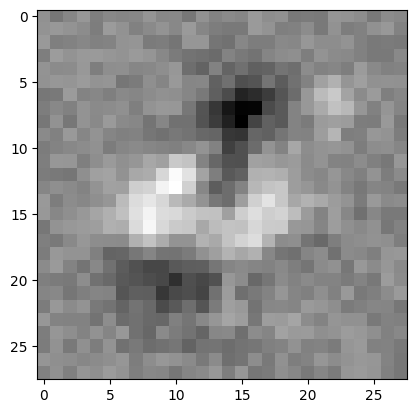

Epoch[41/100]
weight: torch.Size([10, 784])


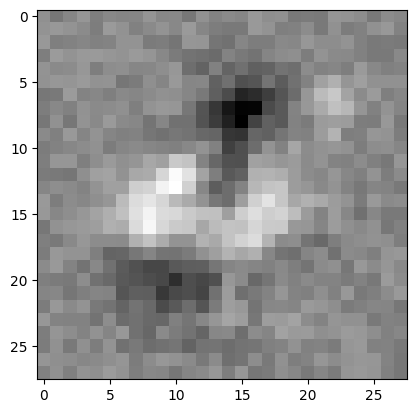

Epoch[42/100]
weight: torch.Size([10, 784])


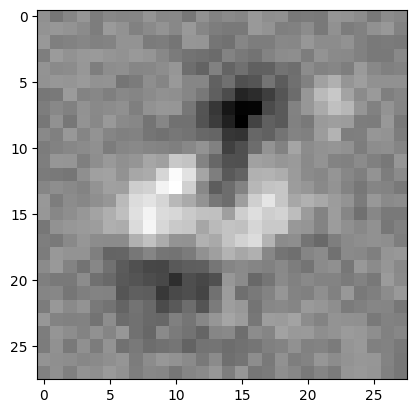

Epoch[43/100]
weight: torch.Size([10, 784])


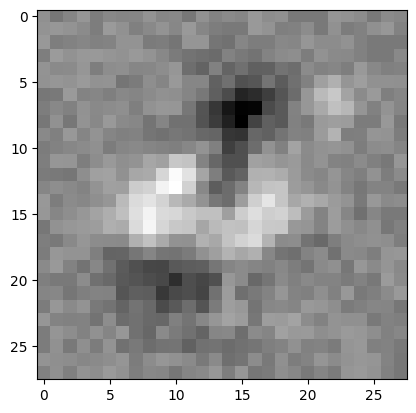

Epoch[44/100]
weight: torch.Size([10, 784])


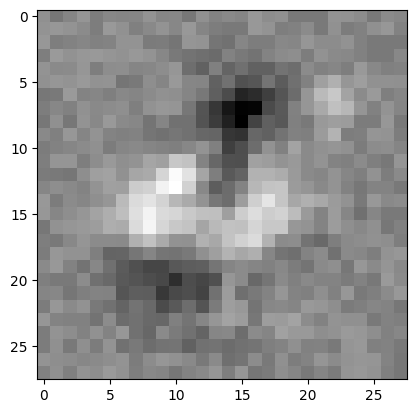

Epoch[45/100]
weight: torch.Size([10, 784])


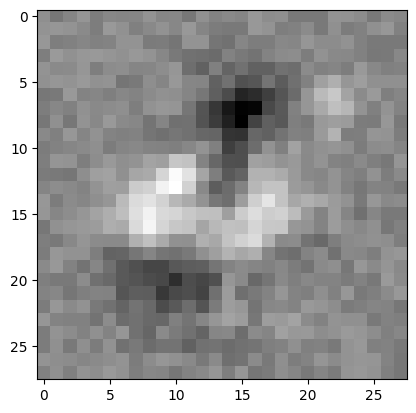

Epoch[46/100]
weight: torch.Size([10, 784])


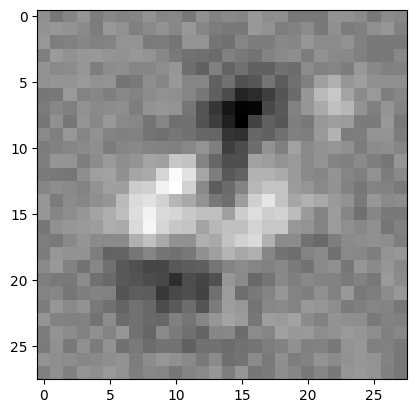

Epoch[47/100]
weight: torch.Size([10, 784])


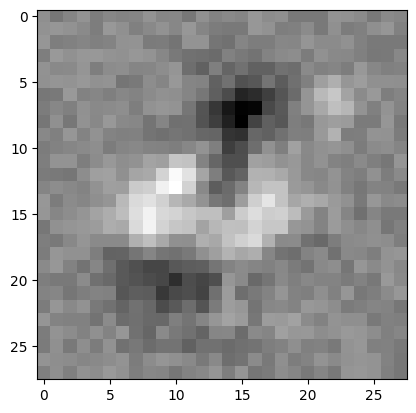

Epoch[48/100]
weight: torch.Size([10, 784])


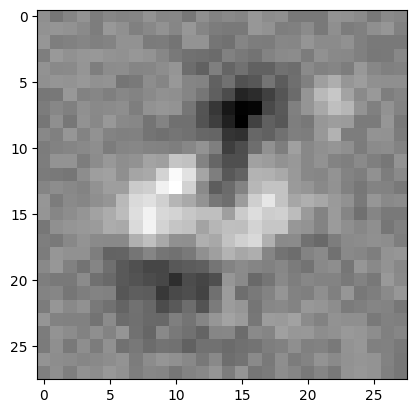

Epoch[49/100]
weight: torch.Size([10, 784])


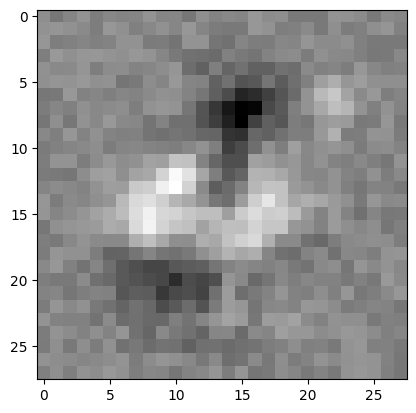

Epoch[50/100]
weight: torch.Size([10, 784])


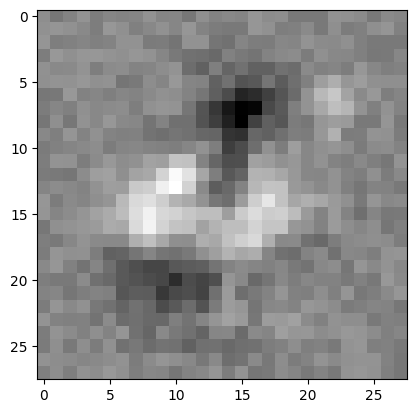

Epoch[51/100]
weight: torch.Size([10, 784])


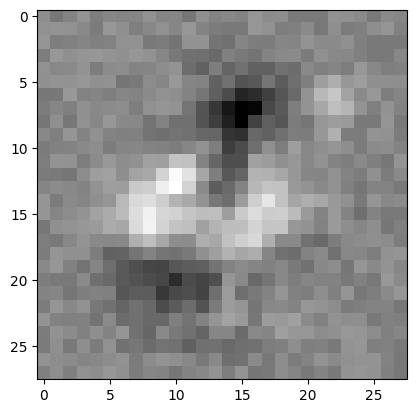

Epoch[52/100]
weight: torch.Size([10, 784])


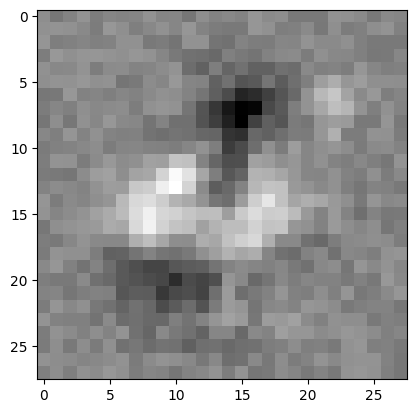

Epoch[53/100]
weight: torch.Size([10, 784])


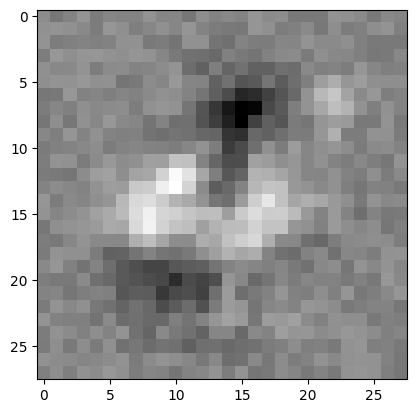

Epoch[54/100]
weight: torch.Size([10, 784])


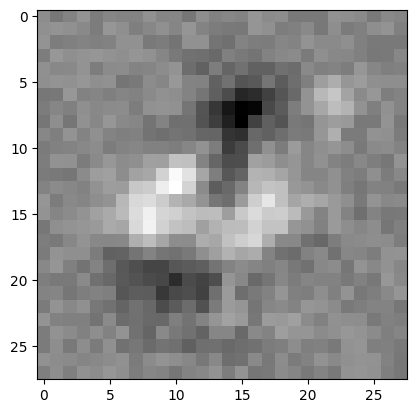

Epoch[55/100]
weight: torch.Size([10, 784])


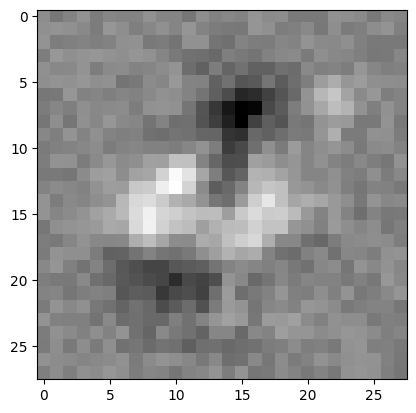

Epoch[56/100]
weight: torch.Size([10, 784])


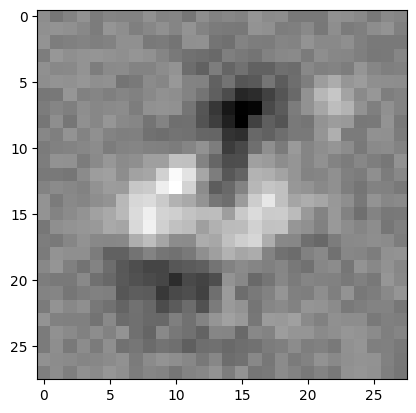

Epoch[57/100]
weight: torch.Size([10, 784])


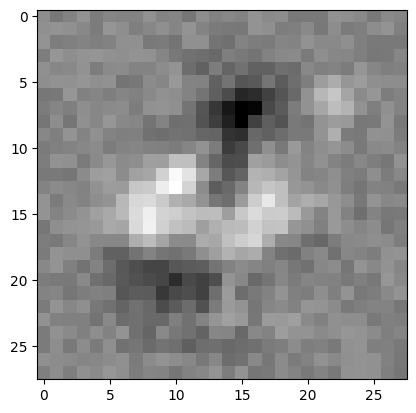

Epoch[58/100]
weight: torch.Size([10, 784])


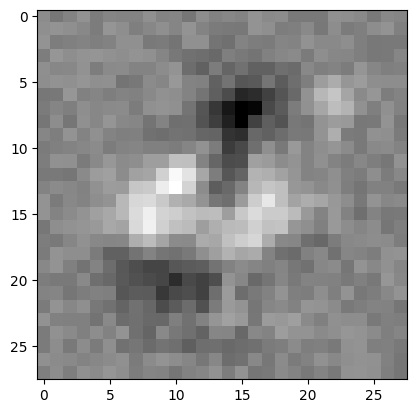

Epoch[59/100]
weight: torch.Size([10, 784])


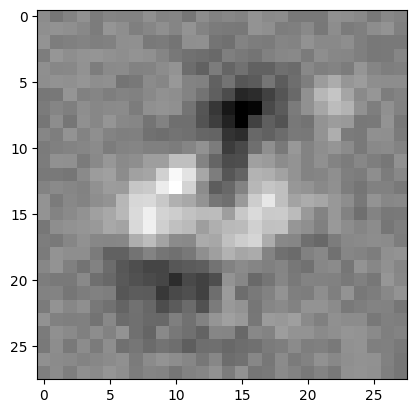

Epoch[60/100]
weight: torch.Size([10, 784])


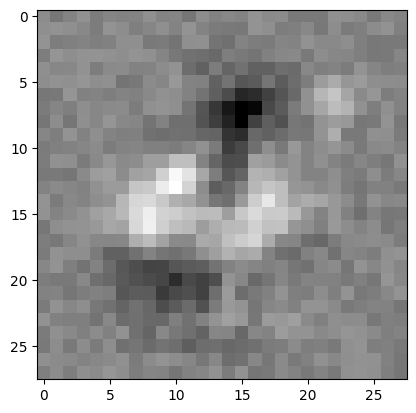

Epoch[61/100]
weight: torch.Size([10, 784])


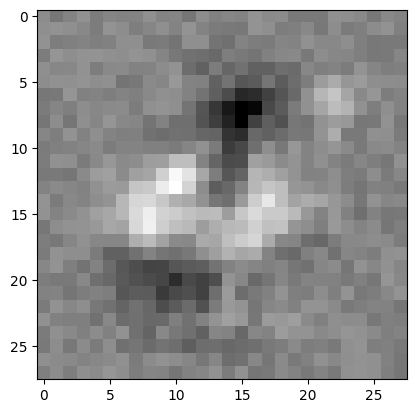

Epoch[62/100]
weight: torch.Size([10, 784])


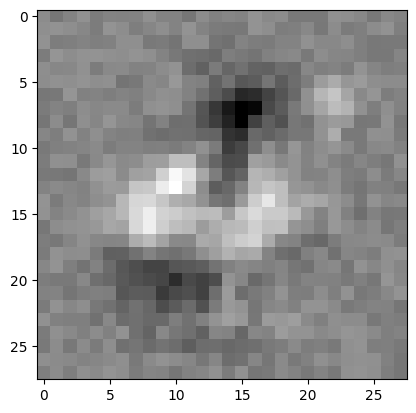

Epoch[63/100]
weight: torch.Size([10, 784])


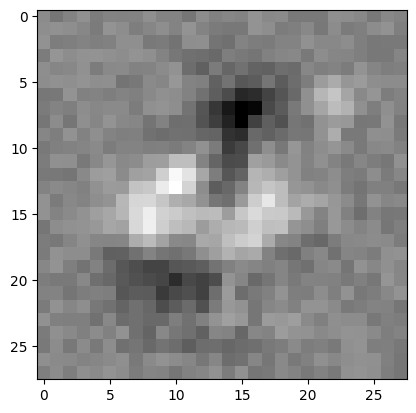

Epoch[64/100]
weight: torch.Size([10, 784])


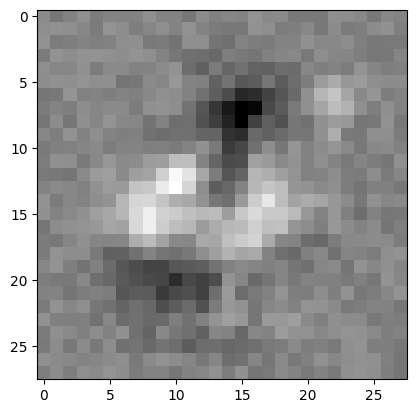

Epoch[65/100]
weight: torch.Size([10, 784])


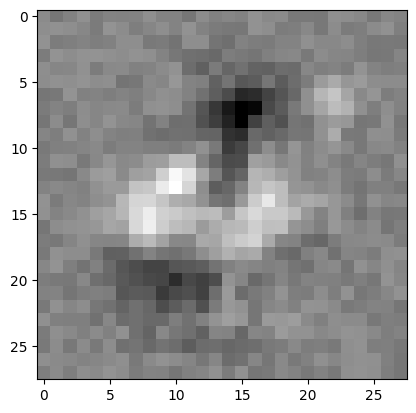

Epoch[66/100]
weight: torch.Size([10, 784])


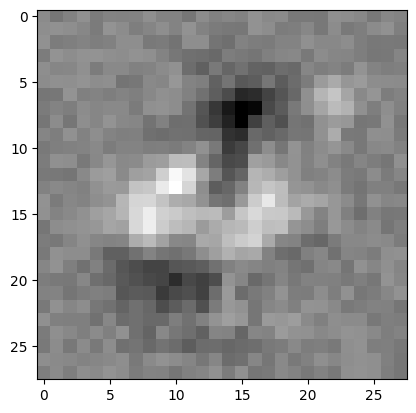

Epoch[67/100]
weight: torch.Size([10, 784])


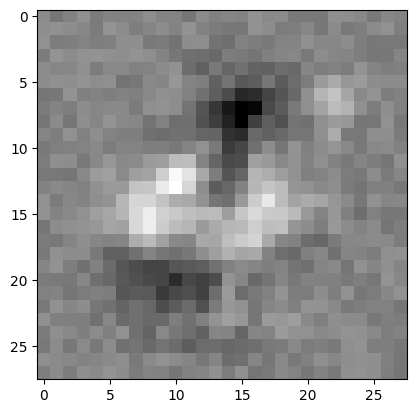

Epoch[68/100]
weight: torch.Size([10, 784])


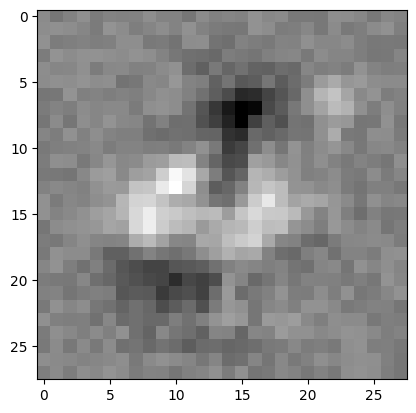

Epoch[69/100]
weight: torch.Size([10, 784])


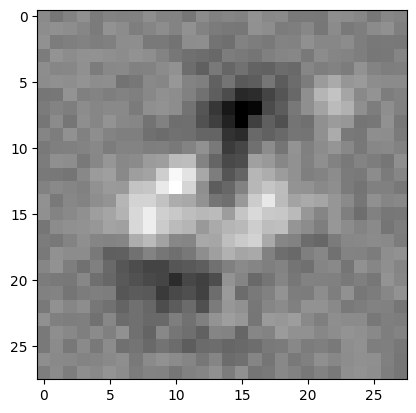

Epoch[70/100]
weight: torch.Size([10, 784])


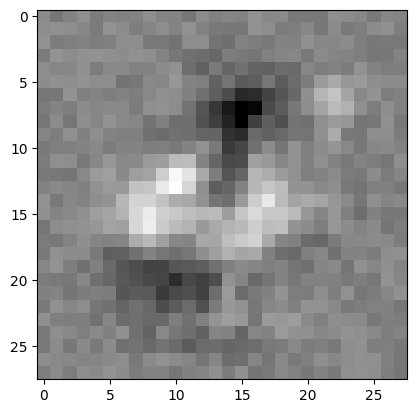

Epoch[71/100]
weight: torch.Size([10, 784])


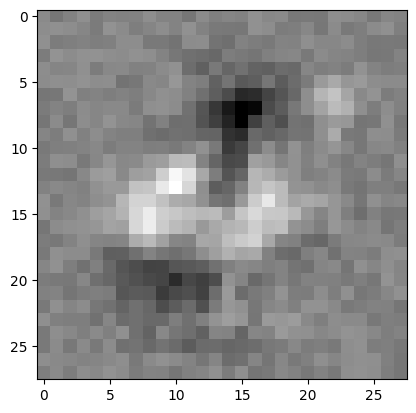

Epoch[72/100]
weight: torch.Size([10, 784])


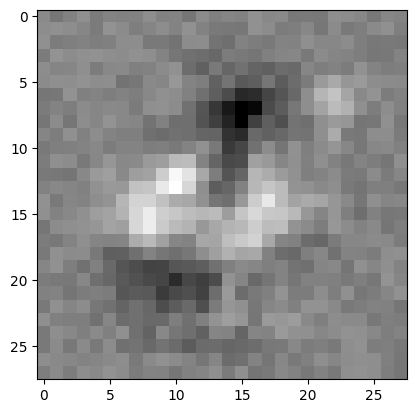

Epoch[73/100]
weight: torch.Size([10, 784])


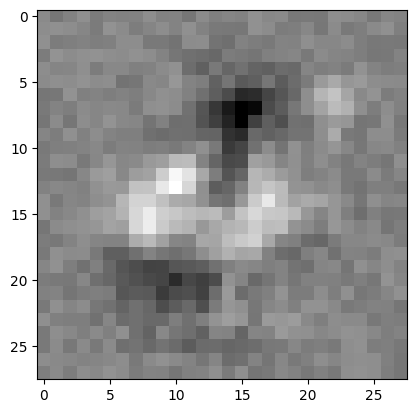

Epoch[74/100]
weight: torch.Size([10, 784])


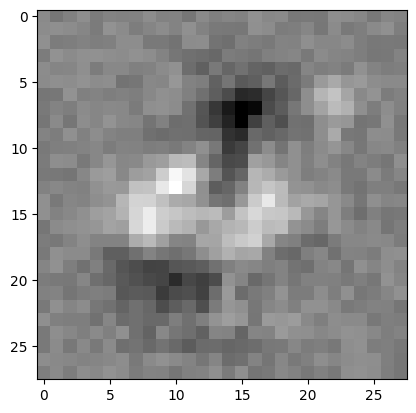

Epoch[75/100]
weight: torch.Size([10, 784])


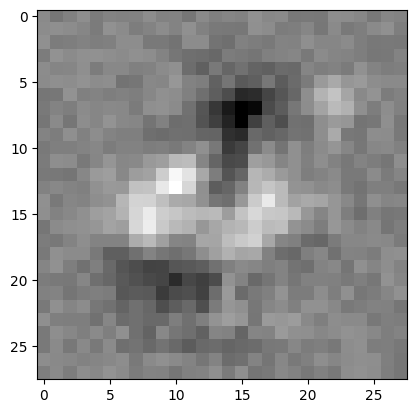

Epoch[76/100]
weight: torch.Size([10, 784])


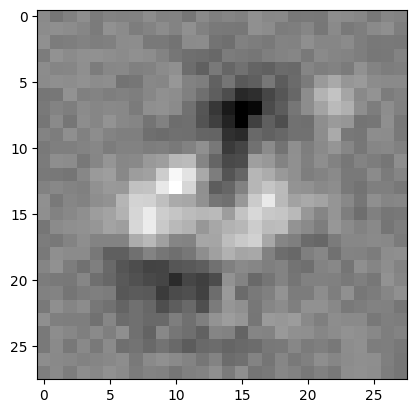

Epoch[77/100]
weight: torch.Size([10, 784])


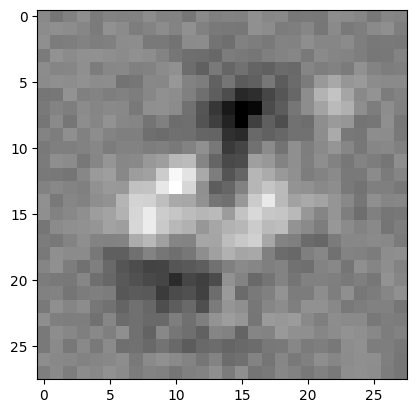

Epoch[78/100]
weight: torch.Size([10, 784])


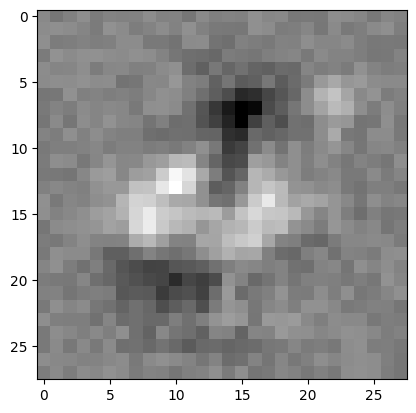

Epoch[79/100]
weight: torch.Size([10, 784])


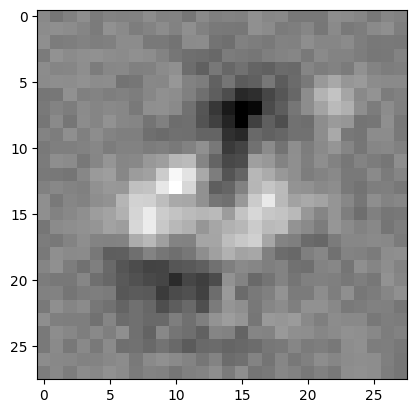

Epoch[80/100]
weight: torch.Size([10, 784])


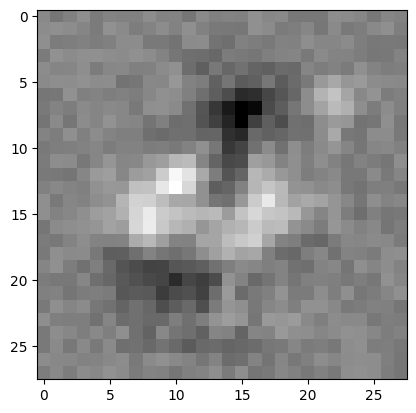

Epoch[81/100]
weight: torch.Size([10, 784])


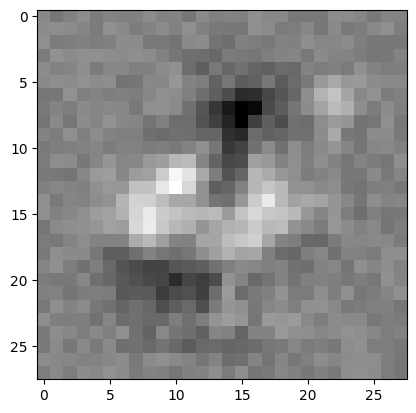

Epoch[82/100]
weight: torch.Size([10, 784])


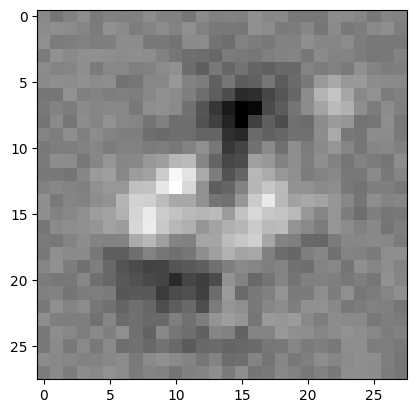

Epoch[83/100]
weight: torch.Size([10, 784])


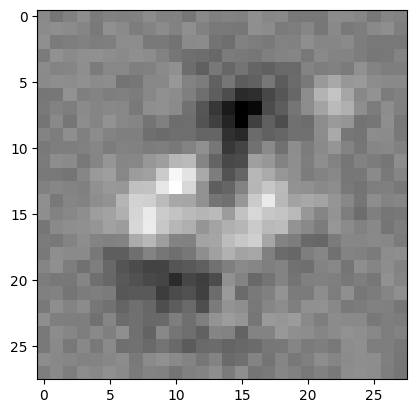

Epoch[84/100]
weight: torch.Size([10, 784])


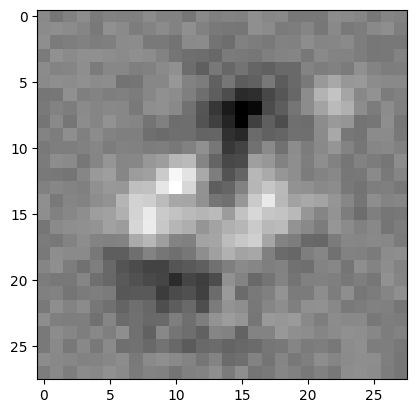

Epoch[85/100]
weight: torch.Size([10, 784])


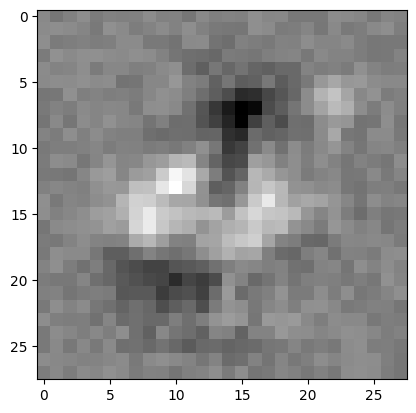

Epoch[86/100]
weight: torch.Size([10, 784])


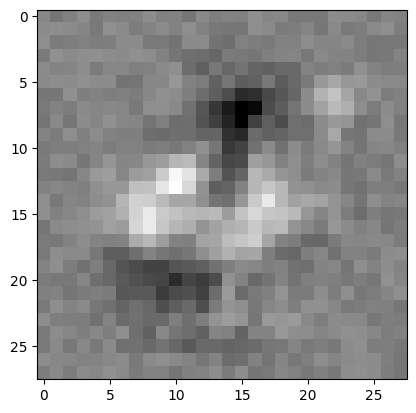

Epoch[87/100]
weight: torch.Size([10, 784])


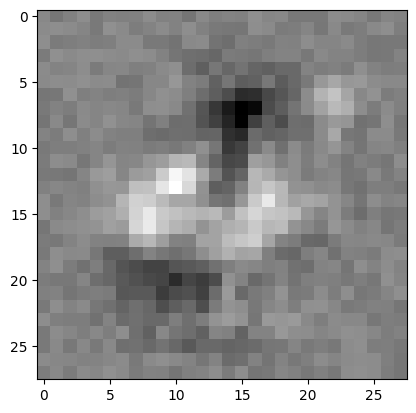

Epoch[88/100]
weight: torch.Size([10, 784])


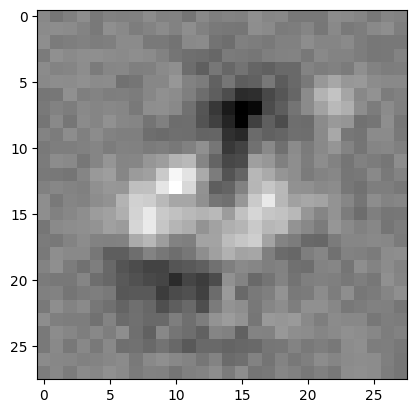

Epoch[89/100]
weight: torch.Size([10, 784])


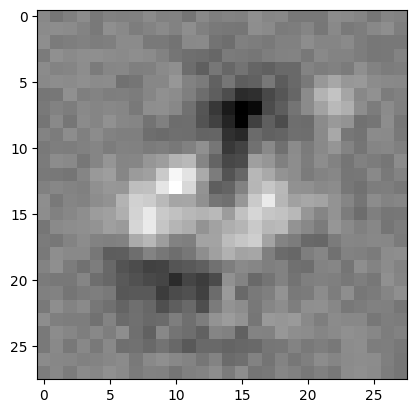

Epoch[90/100]
weight: torch.Size([10, 784])


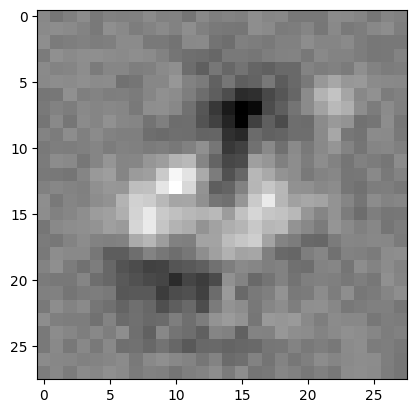

Epoch[91/100]
weight: torch.Size([10, 784])


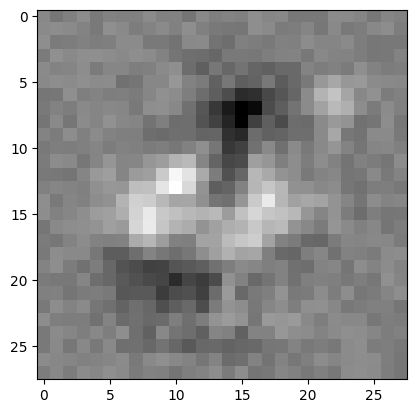

Epoch[92/100]
weight: torch.Size([10, 784])


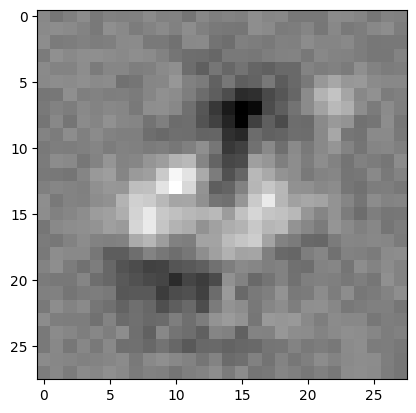

Epoch[93/100]
weight: torch.Size([10, 784])


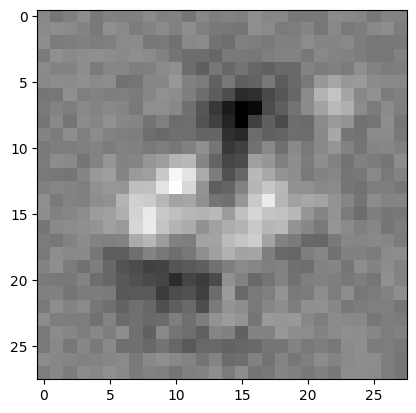

Epoch[94/100]
weight: torch.Size([10, 784])


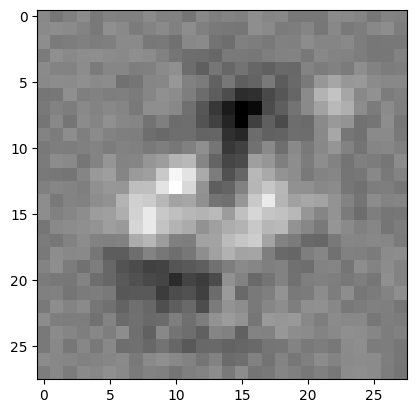

Epoch[95/100]
weight: torch.Size([10, 784])


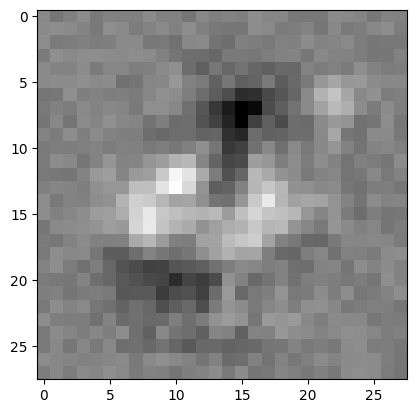

Epoch[96/100]
weight: torch.Size([10, 784])


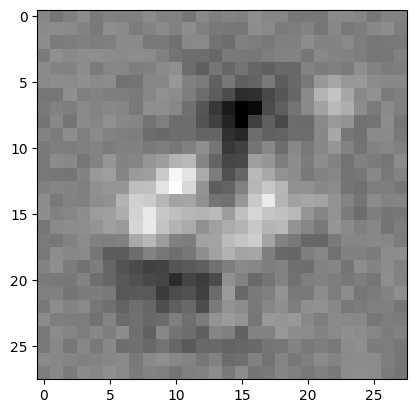

Epoch[97/100]
weight: torch.Size([10, 784])


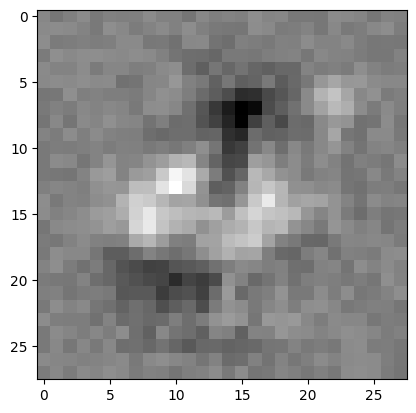

Epoch[98/100]
weight: torch.Size([10, 784])


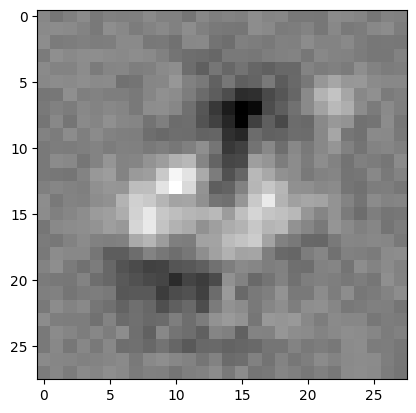

Epoch[99/100]
weight: torch.Size([10, 784])


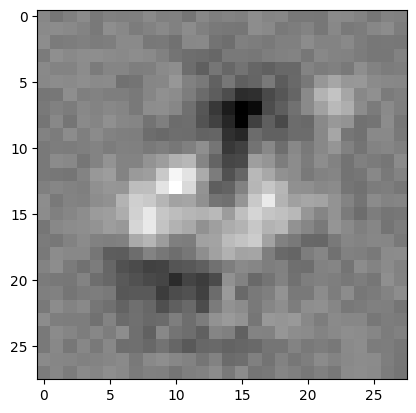

Epoch[100/100]
weight: torch.Size([10, 784])


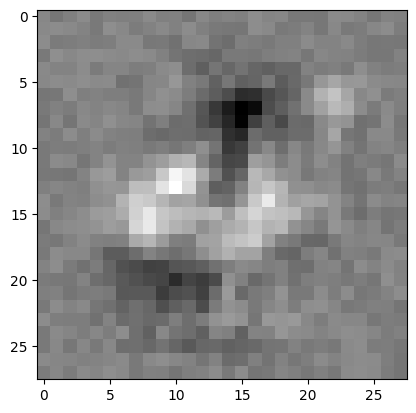

In [92]:
model3 = torch.nn.Linear(28*28, 10) # 28*28 (784) atributos de entrada e 10 neurônios na saída
epochs = 100
learningRate = 0.5

# CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model3.parameters(), lr=learningRate)

import numpy
losses = []
zs = []

for i in range(epochs):
  # Tranformar a entrada para umd imensão
  imputs = x_train.view(-1, 28 * 28)
  # Predict da rede
  outputs = model3(inputs)

  #z0 a z9
  zs.append(outputs[1].detach().numpy())

  # calcula a perda
  loss = criterion(outputs, y_train)

  # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

  _, predicts = torch.max(outputs, 1)

  y_pred = predicts.data
  accuracy = (y_pred.numpy() == y_train.numpy()).mean()
  print('Epoch[{}/{}]'.format(i+1, epochs))

  weights = model3.state_dict()['weight']
  print('weight:', weights.shape)

  # Visualização pesos da classe 4
  plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
  plt.show()


<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
(28*28)
2. Qual é o shape da saída da rede?
(10)
3. Qual é o número total de parâmetros da rede, incluindo o bias?
28*28 * 10 + 10

# Aprendizados
